In [19]:
#Gives sum of next 30 days output expected
#Try add two years ago as well and see what happens. 
#Add more statistics
#Try polynomial predictor and try LSTM see what happens. 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
pd.set_option("display.max_rows",None)
pd.set_option("display.max_columns",None)
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor


In [20]:
electricity_ng = pd.read_csv('Dataset/PV_Elec_Gas2.csv').rename(columns={'Unnamed: 0': 'Date'})
solar_output = pd.read_csv('Dataset/solarpower_cumuldaybyday2.csv').drop(columns='Unnamed: 2')


#electricity_ng

In [21]:
def get_month(x):
    date = datetime.strptime(x, "%Y-%m-%d")
    month = date.month
    return month
def get_yr(x):
    date = datetime.strptime(x, "%Y-%m-%d")
    year = date.year
    return year
def get_day(x):
    date = datetime.strptime(x, "%Y-%m-%d")
    day = date.day
    return day

def days_change(x,y):
    date_1 = datetime.strptime(x, "%Y-%m-%d")
    date_2 = datetime.strptime(y, "%Y-%m-%d")
    chng = (date_2 - date_1).days
    return chng

electricity_ng['month'] = electricity_ng['Date'].apply(get_month)
electricity_ng['year'] = electricity_ng['Date'].apply(get_yr)
electricity_ng['yesterday_power'] = electricity_ng['cum_power'].shift(1)
electricity_ng['yesterday'] = electricity_ng['Date'].shift(1)
electricity_ng = electricity_ng.dropna()
electricity_ng
electricity_ng['days'] = electricity_ng.apply(lambda x: days_change(x['yesterday'], x['Date']),axis=1)
electricity_ng['output/day'] = (electricity_ng['cum_power'] - electricity_ng['yesterday_power'])/electricity_ng['days']
electricity_ng['day_of_month'] = electricity_ng['Date'].apply(get_day)



analyze = electricity_ng[['Date','year', 'month', 'day_of_month', 'output/day']]


display(analyze[analyze['Date'].astype(str).isin(['2013-01-01', '2012-01-01', '2014-01-01', '2015-01-01', '2016-01-01',
                                                 '2017-01-01', '2018-01-01'])])



data_store = pd.DataFrame()
for year in [2011,2012,2013,2014,2015,2016,2017,2018,2019]:
    iter_frame = analyze[analyze['year']==year]
    iter_frame['target'] = iter_frame['output/day'].cumsum()
    if year == 2011:
        data_store = iter_frame
    else:
        data_store = data_store.append(iter_frame)
analyze = data_store



,Date,year,month,day_of_month,output/day
67,2012-01-01,2012,1,1,0.5
433,2013-01-01,2013,1,1,1.1
798,2014-01-01,2014,1,1,2.0
1163,2015-01-01,2015,1,1,3.0
1528,2016-01-01,2016,1,1,4.0
1894,2017-01-01,2017,1,1,2.0
2259,2018-01-01,2018,1,1,1.0


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [22]:
def mv_avg(df):
    mvg_avg_lst = [2,3,4,5,7,10,15,20,25,30,45]
    for i in mvg_avg_lst:
        column_name = 'mv_avg_' + str(i)
        df[column_name] = df.iloc[:,4].rolling(window=i).mean()
    return df
# df = mv_avg(analyze)
# df[df['year']==2013]


In [23]:
#Get moving average this time last year and 1 year before for each date
def year_over_yr(data):
    yr = 2011
    yrs = {}
    target = data[['year', 'month', 'day_of_month', 'target']].copy()
    data = data.drop(columns ='target')
    for i in range(0, (max(data['year']) - yr) + 1):
        frame_name = 'year' + str(yr) + 'data' 
        yrs[frame_name] = data[data['year']==yr]
        yr +=1

    
    #Get_last year
    data_set = {}
    for item in [2013,2014,2015,2016,2017,2018,2019]:
        last_yr = item-1
        lst_yr = 'year' + str(last_yr) + 'data' 
        this_yr = 'year' + str(item) + 'data' 
        
        data_last_year = yrs[lst_yr]
        
        
        for column in data_last_year.columns:
            if 'mv_avg' in column:
                data_last_year = data_last_year.rename(columns={column: 'lst_yr_' + str(column)})

        data_this_year = yrs[this_yr]
        iter_frame = pd.DataFrame()
        data_last_year = data_last_year.drop(columns=['Date', 'year', 'output/day'])
        data_this_year =  data_this_year.drop(columns=['Date', 'year'])
        iter_frame = pd.merge(data_this_year,data_last_year, on =['month', 'day_of_month'], how='left')
        iter_frame.insert(0, 'year', item)
        
        data_set[item] = iter_frame

    final_frame = pd.DataFrame()
    i = 0
    for item in data_set.keys():
        if i == 0:
            final_frame = data_set[item]    
            i+=1
            continue
        final_frame = final_frame.append(data_set[item])
  
    final_frame = pd.merge(final_frame,target, on =['year', 'month', 'day_of_month'],how='left')
    final_frame = final_frame.sort_values(by=['year', 'month', 'day_of_month'], ascending=True)
    return final_frame


# df1 = year_over_yr(df)
# df1[(df1['month']==1) & (df1['year']==2013)]


In [24]:
def past_performance(DF):
    past_performance = DF[['year', 'month', 'day_of_month', 'target']]
    past_performance['year+1'] = past_performance['year'] + 1
    past_performance = past_performance[past_performance['year']!=2011]
    past_stats = {}
    for year in list(set(past_performance['year'])):
        if year not in [2011,2012]:
            Frame_name = str(year) + '_pd'
            iter_frame = past_performance[past_performance['year']<year]
            

            
            past_stats_df = iter_frame[~(iter_frame['target'].isna())].groupby(['month', 'day_of_month'])['target'].agg(['mean', 'std', 'min', 'max']).reset_index()
            last_year = year -1
            last_year_data = iter_frame[iter_frame['year']==last_year]
            last_year_data = last_year_data[['month', 'day_of_month', 'target']]
            last_year_data = last_year_data.rename(columns={'target': 'last_year'})
            put_together = pd.merge(past_stats_df, last_year_data, on =['month', 'day_of_month'],how='left')
            if year == 2014:
                display(put_together)
            
            put_together.insert(0, 'year', year)
            past_stats[Frame_name] = put_together
           
                
            
    return_this = pd.DataFrame()
    for key in past_stats:
        return_this = return_this.append(past_stats[key])
    return return_this











In [25]:
days = []
for i in range(1,32):
    days.append(i)
def day_dums(data):

    data = data[data['year']> 2012]
    day = days
    day_buckets = pd.DataFrame()
    for j in range(0,len(day)):
        start = day[j]
        if j != len(day)-1:
            end = day[j+1]
        else:
            continue
        c_n = 'day>=_' + str(start)+ '_day_<' + str(end)
        day_buckets[c_n] = data.apply(lambda x: 1 if x['day_of_month'] >= start and x['day_of_month'] < end else 0,axis=1)
    day_buckets
    pd.set_option('display.max_rows',300)
    dummies = day_buckets
    merger_data = data[['year', 'month', 'day_of_month']]
    month_dummies = pd.get_dummies(data[data['year']>2012]['month'])
    Trans_frm = merger_data.join(month_dummies)
    Trans_frm = Trans_frm.join(dummies)
    
    return Trans_frm




In [26]:
def pipeline(dataframe):
    dummies = day_dums(dataframe)
    T_2 = year_over_yr(dataframe)
    T = pd.merge(dummies, T_2, on=['year', 'month', 'day_of_month'],how='outer')
    past_data = past_performance(DF=analyze)
    T = pd.merge(T, past_data, on =['year','month', 'day_of_month'])
    
    return T
pd.set_option("display.max_rows",300)


data = pipeline(analyze)
data = data[~(data['std'].isna())]



data = data.drop(columns=['output/day'])
train = data[data['year'] < 2019]
train = train[(train['month']!=2) | (train['day_of_month']!= 29)]

test = data[data['year']==2019]




train = train.drop(columns=['year', 'month', 'day_of_month'])
y = train.pop('target')


actual = test.pop('target')
meta = test[['year', 'month', 'day_of_month']]


test = test.drop(columns=['year', 'month', 'day_of_month'])


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,month,day_of_month,mean,std,min,max,last_year
0,1,1,0.80,0.424264,0.5,1.1,1.1
1,1,2,2.55,1.767767,1.3,3.8,3.8
2,1,3,5.20,1.414214,4.2,6.2,6.2
3,1,4,5.90,1.272792,5.0,6.8,6.8
4,1,5,7.45,0.353553,7.2,7.7,7.2
...,...,...,...,...,...,...,...
361,12,27,3886.05,9.828784,3879.1,3893.0,3879.1
362,12,28,3887.25,10.111627,3880.1,3894.4,3880.1
363,12,29,3889.25,8.697413,3883.1,3895.4,3883.1
364,12,30,3892.70,7.919596,3887.1,3898.3,3887.1


In [27]:
from sklearn.linear_model import LinearRegression


x = train.values
mod = LinearRegression()
mod.fit(x,y)
mod.score(x, y)


#With linear coeff of determinaton = 0.95

0.9970366004818386

In [28]:

pred = mod.predict(test.values)

In [29]:
anal_ize = pd.DataFrame()
anal_ize['actual'] = actual
anal_ize['predicted'] = pred
anal_ize['error'] = abs(anal_ize['actual'] -anal_ize['predicted'])
anal_ize = meta.join(anal_ize)
anal_ize['error'].sum()
anal_ize = anal_ize.dropna()
anal_ize = anal_ize.reset_index(drop=True)
anal_ize['%err'] = anal_ize['error']/anal_ize['actual']

pd.set_option('display.max_rows',None)
#anal_ize



# unit_test = test[300:302].values
# unit_test
# #print(actual.iloc[300])
# mod.predict(unit_test)

#anal_ize.sort_values(by=['error'],ascending=False)

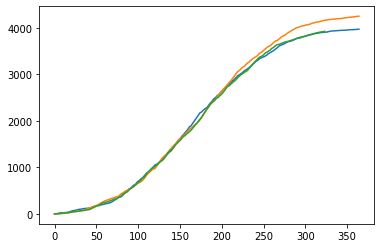

In [30]:

x2017 = data[data['year']==2017].reset_index(drop=True).index
y2017 = data[data['year']==2017]['target']

x2018 = data[data['year']==2018].reset_index(drop=True).index
y2018 = data[data['year']==2018]['target']


x2019 = anal_ize.index
y2019 = anal_ize['actual']



plt.plot(x2017,y2017)
plt.plot(x2018,y2018)
plt.plot(x2019,y2019)


No handles with labels found to put in legend.


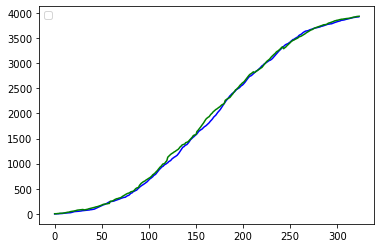

In [31]:
# x = anal_ize['actual']

x = anal_ize.index
y1 = anal_ize['actual']
y2 = anal_ize['predicted']




plt.plot(x,y1, "-b")
plt.plot(x,y2, "-g")
plt.legend(loc="upper left")
plt.show()

#anal_ize



In [32]:
anal_ize['%err'] = (anal_ize['error']/anal_ize['actual'])*100
#err = anal_ize[(anal_ize['month'] > 1) | (anal_ize['day_of_month'] >3)]
anal_ize['%err'].mean()

#anal_ize[anal_ize['month']==6]

10.344474977890263

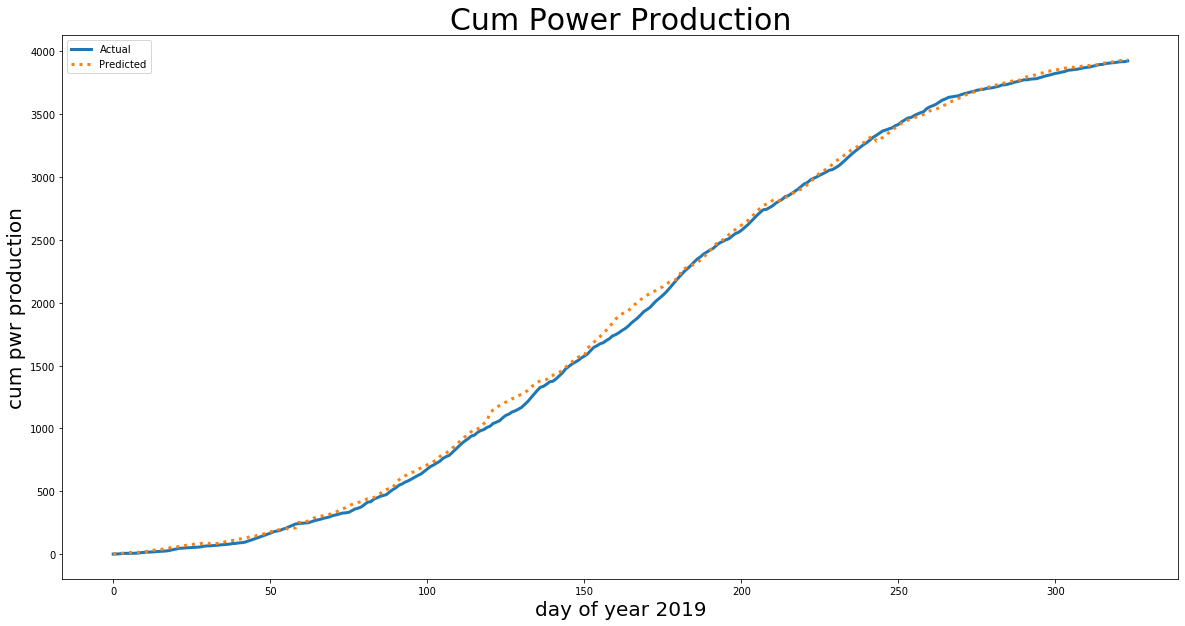

In [33]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
ax.set_title('Cum Power Production', size=30)
ax.plot(x,y1,label='Actual', linewidth=3)
ax.plot(x,y2,label='Predicted', linewidth=3, linestyle=':')
ax.set_xlabel('day of year 2019',size=20)
ax.set_ylabel('cum pwr production', size=20)
#ax.xticks(labelsize=20)
ax.legend(loc='best')
plt.show()
#